In [1]:
from CurveDataFetcher import CurveDataFetcher 
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

from utils.pca import run_pca_yield_curve, create_residuals_surface_plot, plot_residuals_for_date

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), ".env")
print(env_path)
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

import matplotlib.pylab as pylab
params = {
    "legend.fontsize": "x-large",
    "figure.figsize": (20, 10),
    "axes.labelsize": "x-large",
    "axes.titlesize": "x-large",
    "xtick.labelsize": "x-large",
    "ytick.labelsize": "x-large",
}
pylab.rcParams.update(params)
sns.set(style="whitegrid", palette="dark")
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

%load_ext autoreload
%autoreload 2

c:\Users\chris\Curvy-CUSIPs\.env


In [2]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])

In [20]:
# cmt_yields_df = curve_data_fetcher.fred_data_fetcher.get_historical_cmt_yields(
#     start_date=datetime(2000, 1, 1), end_date=datetime(2024, 9, 13)
# )
# cmt_yields_df = cmt_yields_df.dropna()


# cmt_yields_df

# tenors = ["CT3M", "CT6M", "CT1", "CT2", "CT3", "CT5", "CT7", "CT10", "CT20", "CT30"]
# ct_yields_df = curve_data_fetcher.fedinvest_data_fetcher.get_historical_ct_yields(
#     start_date=datetime(2023, 1, 1),
#     end_date=datetime(2024, 9, 12),
#     tenors=tenors,
#     use_mid_side=True,
# )
# ct_yields_df = ct_yields_df.dropna()
# ct_yields_df
# corr_df = ct_yields_df.set_index("Date").corr()
# corr_df.style.background_gradient(
#     sns.diverging_palette(250, 5, as_cmap=True), axis=1
# ).format(precision=6)
# rolling_window = 60
# plt.figure(figsize=(15, 8))
# col1 = "CT30"
# for j, col2 in enumerate(ct_yields_df.columns[3:]):
#     rolling_corr = ct_yields_df[col1].rolling(rolling_window).corr(ct_yields_df[col2])
#     plt.plot(ct_yields_df["Date"], rolling_corr, label=f'{col1} vs {col2}')

# plt.title(f"{rolling_window}d Rolling Corr of {col1}")
# plt.xlabel("Date")
# plt.ylabel('Correlation')
# plt.legend()  
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [14]:
quote_type = "eod"
as_of_date = datetime(2024, 9, 26)

curve_set_df = curve_data_fetcher.build_curve_set(
    as_of_date=as_of_date,
    sorted=True,
    use_github=True,
    include_off_the_run_number=True,
    market_cols_to_return=[f"{quote_type}_price", f"{quote_type}_yield"],
)

curve_set_df = curve_set_df[~curve_set_df["rank"].isin([0, 1, 2, 3, 4, 5, 6])]
curve_set_df = curve_set_df[curve_set_df["time_to_maturity"] > 30 / 360]

curve_set_df = curve_set_df[
    (curve_set_df["original_security_term"] == "5-Year") 
    | (curve_set_df["original_security_term"] == "7-Year") 
    | (curve_set_df["original_security_term"] == "10-Year") 
    # | (curve_set_df["original_security_term"] == "20-Year")
    # | (curve_set_df["original_security_term"] == "30-Year")
]

cusips_ts_dict_df = curve_data_fetcher.fedinvest_data_fetcher.cusips_timeseries(
    cusips=curve_set_df["cusip"]
)
cusips_ts_df = pd.DataFrame()
col = f"{quote_type}_yield"
for name, df in cusips_ts_dict_df.items():
    temp_df = df[["Date", col]].rename(columns={col: name})
    if cusips_ts_df.empty:
        cusips_ts_df = temp_df
    else:
        cusips_ts_df = pd.merge(cusips_ts_df, temp_df, on="Date", how="outer")

cusips_ts_df = cusips_ts_df.dropna()
cusips_ts_df

,Date,912828YM6,912828YV6,912828YY0,912828Z52,912828ZC7,912828ZF0,912828ZL7,912828ZT0,912828ZW3,...,91282CAE1,91282CAV3,91282CBL4,91282CCB5,91282CCS8,91282CDJ7,91282CDY4,91282CEP2,91282CFF3,91282CFV8
2299,2024-02-01,4.916860,4.895231,4.799365,4.725882,4.661744,4.612396,4.534126,4.493680,4.438346,...,3.841847,3.810530,3.754094,3.819542,3.829879,3.842463,3.853479,3.860511,3.867836,3.861501
2300,2024-02-02,5.044515,5.009825,4.899827,4.854259,4.814626,4.758595,4.725797,4.674148,4.608291,...,4.030366,3.991124,3.944006,4.006468,4.009936,4.022387,4.030025,4.034025,4.038454,4.034072
2301,2024-02-05,5.102689,5.062049,4.945972,4.897558,4.855694,4.827364,4.790364,4.760681,4.714167,...,4.174893,4.135717,4.088450,4.144731,4.152410,4.166043,4.172280,4.176225,4.178220,4.175038
2302,2024-02-06,5.071266,5.033438,4.918797,4.873376,4.802395,4.749845,4.745313,4.666853,4.649752,...,4.101501,4.065116,4.014809,4.073970,4.082465,4.098012,4.107077,4.110177,4.113381,4.106458
2303,2024-02-07,5.084800,5.045369,4.928372,4.883018,4.812036,4.760131,4.727618,4.676111,4.633982,...,4.084284,4.048455,3.998705,4.058355,4.067137,4.083059,4.087574,4.091620,4.095204,4.089361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,2024-09-20,5.120309,4.889794,4.789758,4.692870,4.609930,4.375120,4.306768,4.259906,4.127421,...,3.556871,3.556702,3.540924,3.590536,3.602213,3.615557,3.637997,3.633875,3.649352,3.645706
2461,2024-09-23,5.218032,4.766764,4.820473,4.535441,4.556161,4.333018,4.324961,4.228242,4.141331,...,3.584238,3.582833,3.571826,3.619878,3.631233,3.643619,3.659404,3.663319,3.673442,3.667522
2462,2024-09-24,5.000911,4.816037,4.731306,4.559864,4.501760,4.353827,4.288620,4.196346,4.069456,...,3.553016,3.552803,3.542892,3.592081,3.603975,3.617201,3.639184,3.639241,3.654644,3.649845
2463,2024-09-25,5.100841,4.866828,4.762067,4.584672,4.523309,4.374868,4.306902,4.164213,4.083258,...,3.599965,3.597703,3.591815,3.638630,3.655586,3.667134,3.686688,3.688237,3.702655,3.698087


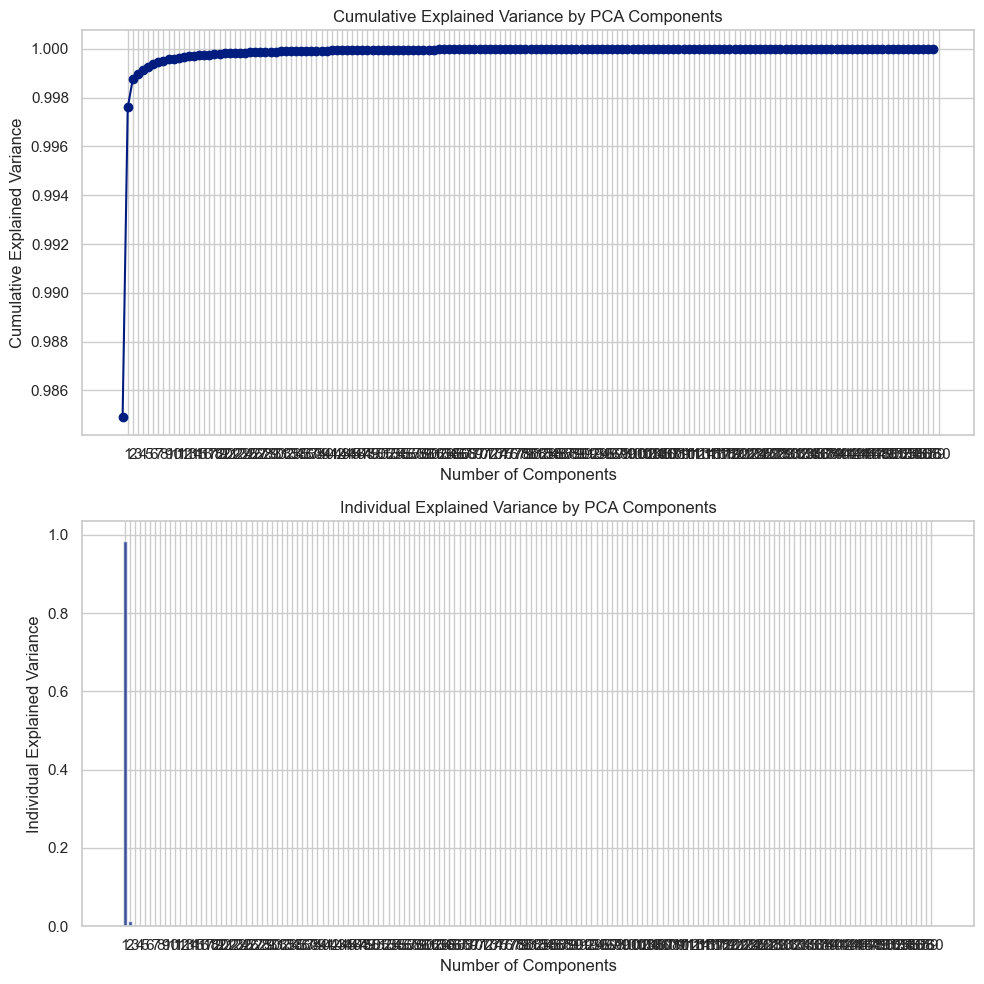

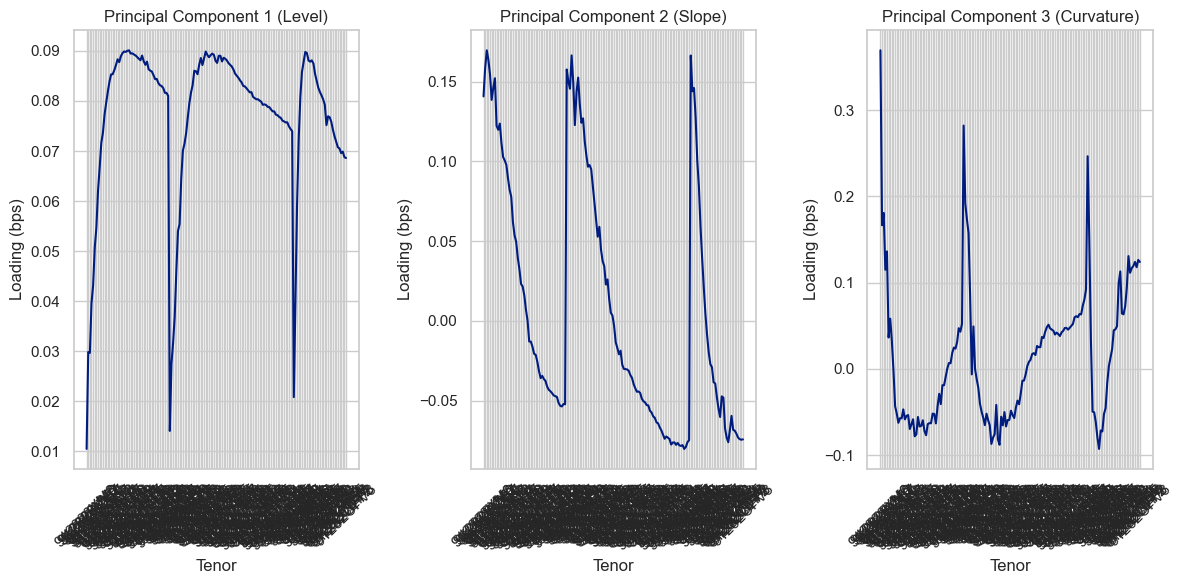


Reconstruction Error (MSE): 0.0001467545357980983


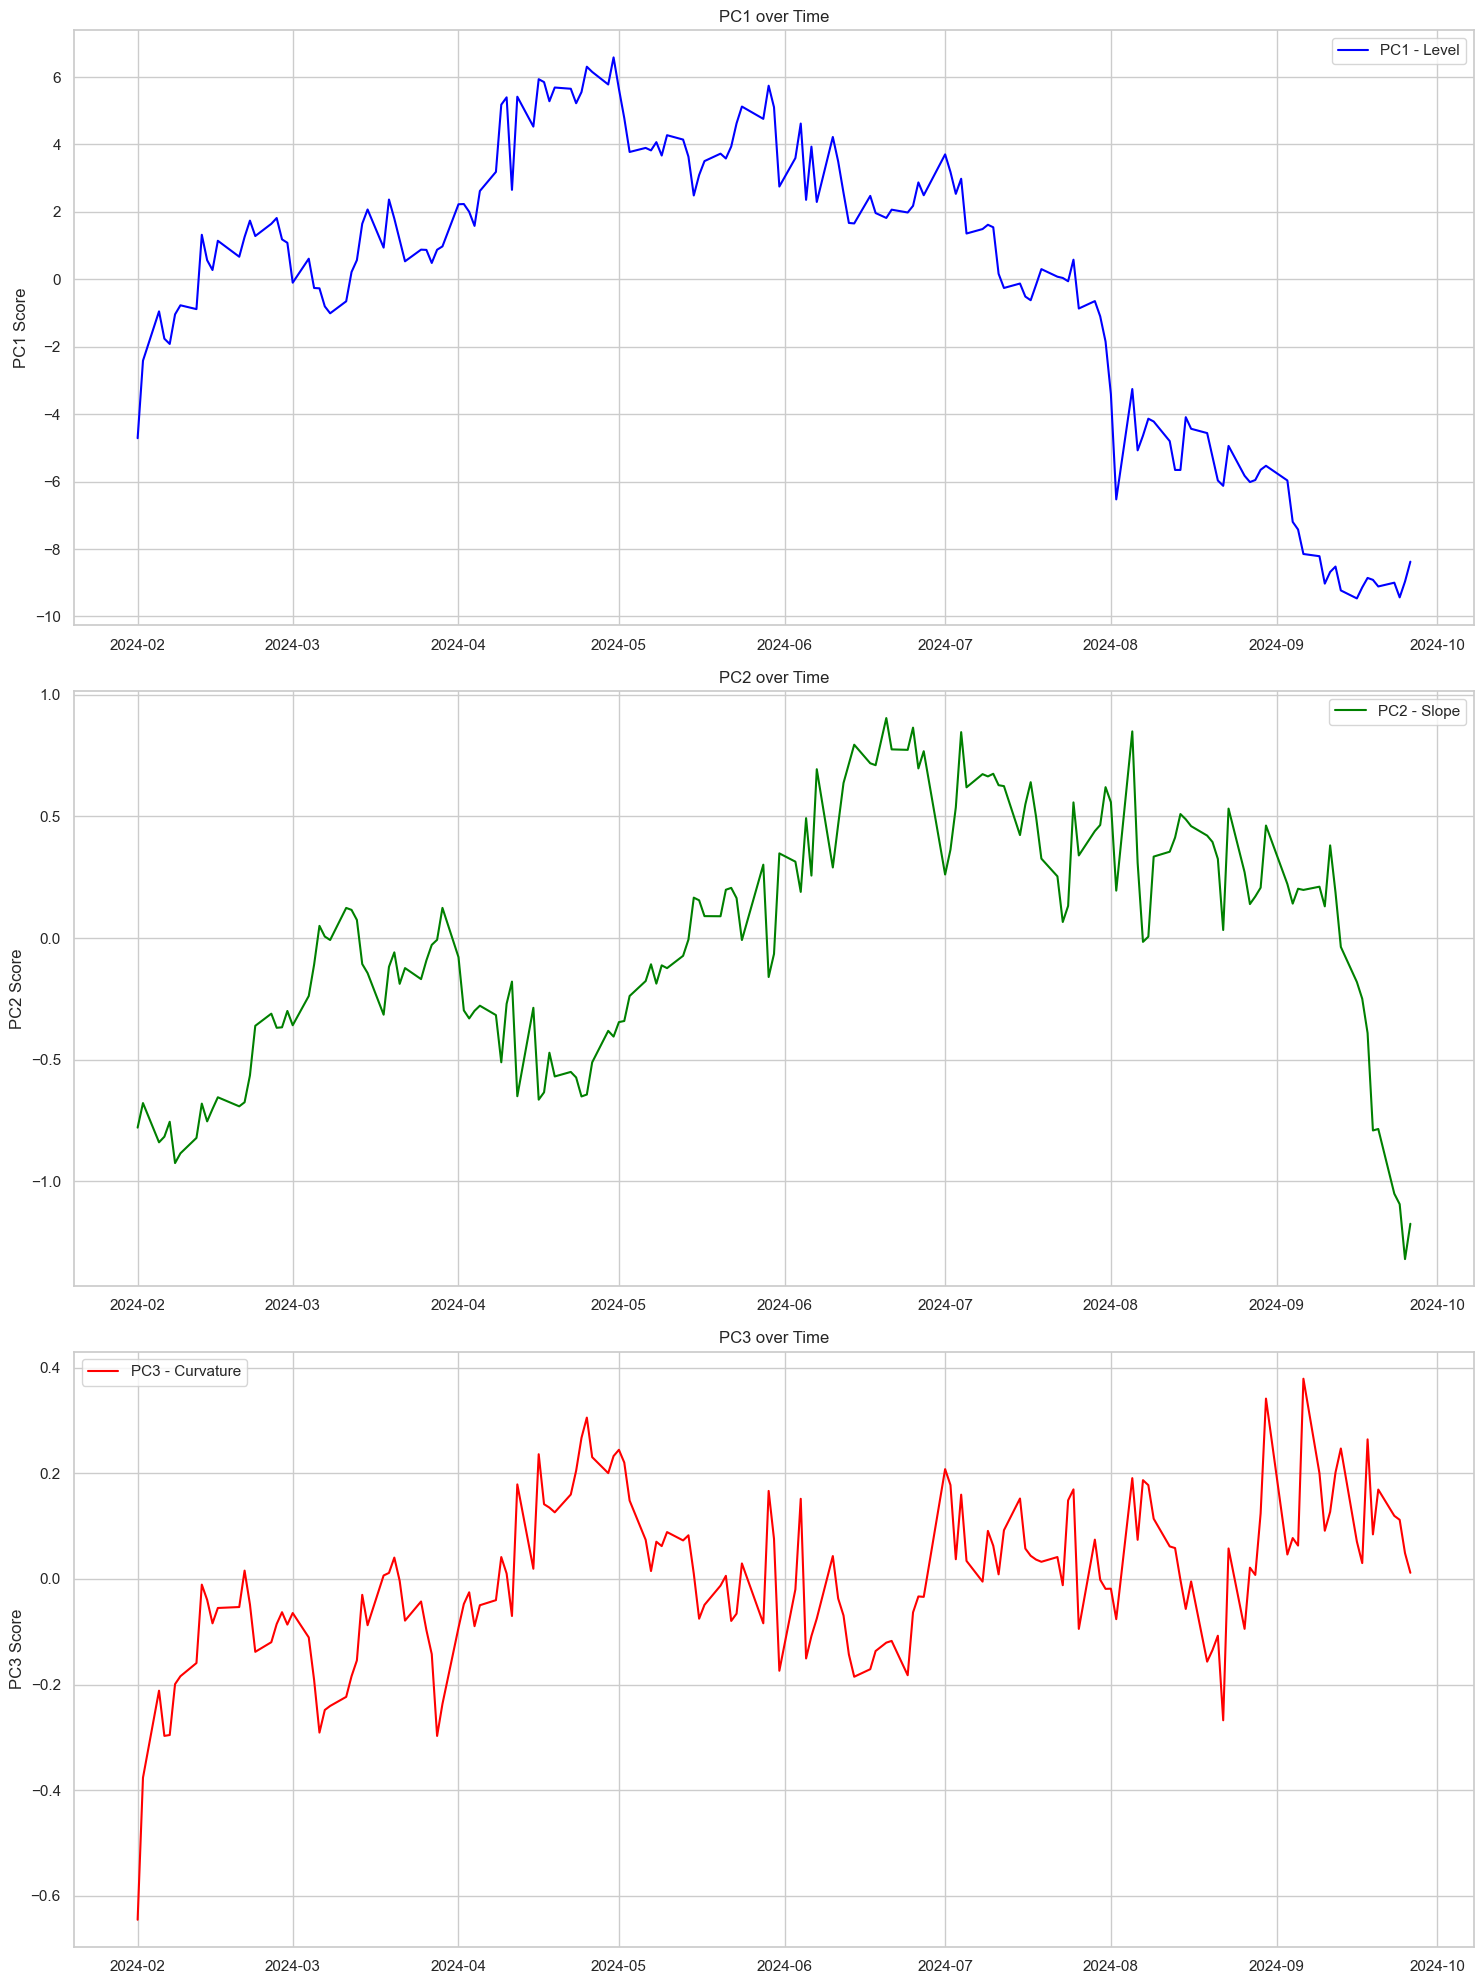

In [15]:
pc3_ct_df = run_pca_yield_curve(
    df=cusips_ts_df.set_index("Date"),
    is_cusips=True,
    n_components=3,
    # run_on_diff=True,
    show_cumul_ex_var=True,
    show_eigenvectors=True,
    show_pc_scores_timeseries=True,
    show_reconstructed=True,
    show_3d_plot=True
)

In [16]:
residuals_df = pd.DataFrame(
    cusips_ts_df.set_index("Date").values - pc3_ct_df["reconstructed_df"].values,
    columns=pc3_ct_df["reconstructed_df"].columns,
    index=pc3_ct_df["reconstructed_df"].index,
)
residuals_df

,912828YM6,912828YV6,912828YY0,912828Z52,912828ZC7,912828ZF0,912828ZL7,912828ZT0,912828ZW3,91282CAB7,...,91282CAE1,91282CAV3,91282CBL4,91282CCB5,91282CCS8,91282CDJ7,91282CDY4,91282CEP2,91282CFF3,91282CFV8
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-01,0.004495,0.003790,0.003796,0.002855,-0.005066,-0.001205,-0.014202,0.002581,-0.006197,-0.008720,...,0.006195,0.005692,0.002309,0.001240,0.007065,0.008378,0.010689,0.010256,0.014899,0.010023
2024-02-02,-0.005602,-0.011055,-0.029783,-0.007280,-0.003660,0.004610,0.021245,0.016257,-0.001371,0.009472,...,0.008552,-0.002782,-0.004634,-0.000135,-0.000060,0.001170,0.001179,-0.001184,0.000857,-0.001078
2024-02-05,-0.000948,-0.004390,-0.029481,-0.014439,-0.023254,0.015588,0.019816,0.031241,0.027099,0.008248,...,0.018031,0.006773,0.002045,0.003714,0.008613,0.010646,0.009437,0.007446,0.007222,0.007144
2024-02-06,0.004509,0.001789,-0.021039,-0.000469,-0.033484,-0.020928,0.020698,-0.013041,0.013703,-0.001193,...,0.014016,0.005927,0.000047,0.002272,0.007578,0.011596,0.012930,0.009822,0.010645,0.006487
2024-02-07,0.010424,0.008377,-0.017552,0.005111,-0.026814,-0.011302,0.002461,-0.003503,0.000819,0.010747,...,0.013181,0.004895,-0.001233,0.001881,0.007332,0.011799,0.008577,0.006535,0.007571,0.004461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-20,-0.046327,-0.005361,-0.021806,0.051180,0.022696,-0.044396,-0.047609,0.015774,-0.021750,-0.010605,...,-0.005137,0.000995,0.002769,-0.003097,-0.005032,-0.006084,-0.000306,-0.005604,-0.004540,-0.005532
2024-09-23,0.106095,-0.081296,0.059749,-0.061409,0.011954,-0.053483,0.006277,0.019280,0.017172,-0.015372,...,-0.002884,0.005296,0.016165,0.005574,0.003546,0.001188,0.000023,0.002145,-0.001684,-0.004997
2024-09-24,-0.097654,-0.010982,-0.007855,-0.011852,-0.016003,-0.004362,0.000482,0.021183,-0.020420,-0.005982,...,-0.003800,0.005369,0.017425,0.006985,0.005038,0.003355,0.007921,0.006219,0.007239,0.004968


In [ ]:
create_residuals_surface_plot(
    residuals_df=pd.DataFrame(
        cusips_ts_df.set_index("Date").values - pc3_ct_df["reconstructed_df"].values,
        columns=pc3_ct_df["reconstructed_df"].columns,
        index=pc3_ct_df["reconstructed_df"].index,
    )
)

In [17]:
plot_residuals_for_date(
    residuals_df=pd.DataFrame(
        cusips_ts_df.set_index("Date").values - pc3_ct_df["reconstructed_df"].values,
        columns=pc3_ct_df["reconstructed_df"].columns,
        index=pc3_ct_df["reconstructed_df"].index,
    ),
    date=datetime(2024, 9, 4),
)

In [ ]:
# https://github.com/letianzj/QuantResearch/blob/master/notebooks/ch1_pca_relative_value.ipynb
# https://developers.lseg.com/en/article-catalog/article/yield-curve-principal-component-analysis-with-eikon-data-api
# https://github.com/LSEG-API-Samples/Example.EikonAPI.Python.PCAYC
# https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
# Huggins/Schaller RV Reading

In [ ]:
srf_dict_df = curve_data_fetcher.wsj_data_fetcher.wsj_timeseries_api(
    wsj_ticker_keys=[
        "FUTURE/US/XCME/SR3CU24",
        "FUTURE/US/XCME/SR3CZ24",
        "FUTURE/US/XCME/SR3CH25",
        "FUTURE/US/XCME/SR3CM25",
        "FUTURE/US/XCME/SR3CU25",
        "FUTURE/US/XCME/SR3CZ25",
        "FUTURE/US/XCME/SR3CH26",
        "FUTURE/US/XCME/SR3CM26",
        "FUTURE/US/XCME/SR3CU26",
        "FUTURE/US/XCME/SR3CZ26",
        "FUTURE/US/XCME/SR3CH27",
        "FUTURE/US/XCME/SR3CM27",
        "FUTURE/US/XCME/SR3CU27",
        "FUTURE/US/XCME/SR3CZ27",
        "FUTURE/US/XCME/SR3CH28",
        "FUTURE/US/XCME/SR3CM28",
        "FUTURE/US/XCME/SR3CU28",
        "FUTURE/US/XCME/SR3CZ28",
    ]
)

srf_df = reduce(
    lambda left, right: pd.merge(left, right, on="Date", how="outer"),
    srf_dict_df.values(),
)
srf_df.columns = [col_str.split("/")[-1] for col_str in srf_df.columns]
srf_df = srf_df[srf_df["Date"] > datetime(2024, 1, 1)]

srf_df

In [39]:
corr_df = srf_df.set_index("Date").corr()
corr_df.style.background_gradient(
    sns.diverging_palette(250, 5, as_cmap=True), axis=1
).format(precision=6)

,SR3CU24,SR3CZ24,SR3CH25,SR3CM25,SR3CU25,SR3CZ25,SR3CH26,SR3CM26,SR3CU26,SR3CZ26,SR3CH27,SR3CM27,SR3CU27,SR3CZ27,SR3CH28,SR3CM28,SR3CU28,SR3CZ28
SR3CU24,1.000000,0.898503,0.780016,0.720410,0.680911,0.635424,0.578487,0.524220,0.486345,0.458563,0.429852,0.397805,0.371305,0.347082,0.326502,0.299158,0.276330,0.266490
SR3CZ24,0.898503,1.000000,0.974987,0.949822,0.929717,0.904319,0.869932,0.834549,0.807885,0.787318,0.765890,0.741647,0.721034,0.701795,0.685356,0.663708,0.645292,0.637252
SR3CH25,0.780016,0.974987,1.000000,0.995242,0.987139,0.974294,0.954320,0.931423,0.912650,0.897488,0.881540,0.863109,0.847138,0.831936,0.818831,0.801621,0.786685,0.780057
SR3CM25,0.720410,0.949822,0.995242,1.000000,0.997918,0.991283,0.978243,0.961323,0.946449,0.934014,0.920764,0.905124,0.891445,0.878263,0.866827,0.851747,0.838488,0.832482
SR3CU25,0.680911,0.929717,0.987139,0.997918,1.000000,0.997666,0.989333,0.976450,0.964292,0.953788,0.942387,0.928679,0.916569,0.904811,0.894598,0.881029,0.868980,0.863408
SR3CZ25,0.635424,0.904319,0.974294,0.991283,0.997666,1.000000,0.996907,0.988648,0.979660,0.971425,0.962175,0.950744,0.940484,0.930383,0.921553,0.909707,0.899061,0.894002
SR3CH26,0.578487,0.869932,0.954320,0.978243,0.989333,0.996907,1.000000,0.997353,0.992262,0.986825,0.980248,0.971654,0.963648,0.955564,0.948343,0.938542,0.929559,0.925102
SR3CM26,0.524220,0.834549,0.931423,0.961323,0.976450,0.988648,0.997353,1.000000,0.998633,0.995888,0.991869,0.986021,0.980184,0.974015,0.968290,0.960395,0.952975,0.949102
SR3CU26,0.486345,0.807885,0.912650,0.946449,0.964292,0.979660,0.992262,0.998633,1.000000,0.999239,0.997089,0.993243,0.988991,0.984224,0.979595,0.973070,0.966777,0.963334
SR3CZ26,0.458563,0.787318,0.897488,0.934014,0.953788,0.971425,0.986825,0.995888,0.999239,1.000000,0.999271,0.996933,0.993877,0.990186,0.986404,0.980900,0.975446,0.972331


In [43]:
l = [1, 2]
l[1:]

[2]